In [ ]:
!pip install stargazer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import statsmodels.stats.power as smp
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from stargazer.stargazer import Stargazer
import seaborn as sns

# **Preliminary Power Analysis to Determine the Required Number of Observations for the Experiment**

In [ ]:
effect_size = 0.5
alpha = 0.05
power = 0.8
num_posters = 5

# Since each poster has a treatment and control, we consider the number of units to be the number of posters.

analysis = smp.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)

print(f'Number of observations per group per poster required: {result:.2f}')
print(f'Total number of observations per group: {result * num_posters:.2f}')
print(f'Total number of observations needed in total: {2*result*num_posters:.2f}')
print(f'Minimum number of survey respondents needed in total: {0.4*result*num_posters:.0f}')

Number of observations per group per poster required: 63.77
Total number of observations per group: 318.83
Total number of observations needed in total: 637.66
Minimum number of survey respondents needed in total: 128


In [ ]:
data = {
    'Observations': ['Per Group per Poster', 'Total per Group', 'Total Needed'],
    'Value': [result, result * num_posters, 2 * result * num_posters]
}

# Create a pandas DataFrame
table = pd.DataFrame(data)

# Display the table
print(table.to_string(index=False))

        Observations      Value
Per Group per Poster  63.765612
     Total per Group 318.828059
        Total Needed 637.656118


# **Load Extracted Data from Qualtrics**

In [ ]:
movies_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1DigN4OQFS7z_uXOVmHWsYHGkz03tippk')

movies_data.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Unfriended Treatment_1,Unfriended Treatment_2,Unfriended Control_1,Unfriended Control_2,Companion Random,IT Random,Midsommar Random,Rings Random,Saw Random,Unfriended Random
0,2/26/2025 12:45,2/26/2025 12:47,0,104.28.50.175,100,136,1,2/26/2025 12:47,R_7fuEx5ilVqT4Qi2,NaN,...,NaN,NaN,6.0,8.0,1,4,5,8,9,12
1,2/26/2025 12:55,2/26/2025 12:56,0,12.203.209.73,100,92,1,2/26/2025 12:56,R_1MVYnF0EFTJF2Gb,NaN,...,NaN,NaN,3.0,9.0,2,4,6,7,10,12
2,2/26/2025 12:58,2/26/2025 13:01,0,73.114.151.137,100,190,1,2/26/2025 13:01,R_1PsG3ojlZTUTWZX,NaN,...,NaN,NaN,9.0,6.0,1,3,6,7,10,11
3,2/26/2025 13:10,2/26/2025 13:12,0,49.207.217.77,100,113,1,2/26/2025 13:12,R_4YguBzYjWukNqBX,NaN,...,3.0,4.0,NaN,NaN,2,4,5,8,9,12
4,2/26/2025 13:16,2/26/2025 13:18,0,45.127.44.96,100,109,1,2/26/2025 13:18,R_4gZRXz3YsEyyASg,NaN,...,NaN,NaN,4.0,3.0,1,3,6,7,10,12


In [ ]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StartDate               172 non-null    object 
 1   EndDate                 172 non-null    object 
 2   Status                  172 non-null    int64  
 3   IPAddress               172 non-null    object 
 4   Progress                172 non-null    int64  
 5   Duration (in seconds)   172 non-null    int64  
 6   Finished                172 non-null    int64  
 7   RecordedDate            172 non-null    object 
 8   ResponseId              172 non-null    object 
 9   RecipientLastName       0 non-null      float64
 10  RecipientFirstName      0 non-null      float64
 11  RecipientEmail          0 non-null      float64
 12  ExternalReference       0 non-null      float64
 13  LocationLatitude        172 non-null    float64
 14  LocationLongitude       172 non-null    fl

# **Data Cleaning**

In [ ]:
# Looking at the non-null values for Gender fill-in-the-blank
movies_data[pd.notna(movies_data['Gender_4_TEXT'])]

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Unfriended Treatment_1,Unfriended Treatment_2,Unfriended Control_1,Unfriended Control_2,Companion Random,IT Random,Midsommar Random,Rings Random,Saw Random,Unfriended Random
11,2/26/2025 13:55,2/26/2025 13:56,0,107.115.29.125,100,88,1,2/26/2025 13:56,R_7K7FBmCGDxrEO8J,NaN,...,NaN,NaN,10.0,1.0,1,4,6,7,9,11
45,2/26/2025 17:50,2/26/2025 17:52,0,74.105.9.162,100,116,1,2/26/2025 17:52,R_767RqfrPDYLhAo9,NaN,...,NaN,NaN,7.0,9.0,1,3,6,8,10,12
49,2/26/2025 18:06,2/26/2025 18:08,0,130.44.118.216,100,119,1,2/26/2025 18:08,R_32YefVbkTl9S0Jw,NaN,...,10.0,9.0,NaN,NaN,1,4,6,8,10,11


In [ ]:
# Convert non-nulls to one group 'Other'
movies_data.loc[movies_data['Gender_4_TEXT'].notnull(), 'Gender_4_TEXT'] = 'Other'

# Sanity check
movies_data[pd.notna(movies_data['Gender_4_TEXT'])]

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Unfriended Treatment_1,Unfriended Treatment_2,Unfriended Control_1,Unfriended Control_2,Companion Random,IT Random,Midsommar Random,Rings Random,Saw Random,Unfriended Random
11,2/26/2025 13:55,2/26/2025 13:56,0,107.115.29.125,100,88,1,2/26/2025 13:56,R_7K7FBmCGDxrEO8J,NaN,...,NaN,NaN,10.0,1.0,1,4,6,7,9,11
45,2/26/2025 17:50,2/26/2025 17:52,0,74.105.9.162,100,116,1,2/26/2025 17:52,R_767RqfrPDYLhAo9,NaN,...,NaN,NaN,7.0,9.0,1,3,6,8,10,12
49,2/26/2025 18:06,2/26/2025 18:08,0,130.44.118.216,100,119,1,2/26/2025 18:08,R_32YefVbkTl9S0Jw,NaN,...,10.0,9.0,NaN,NaN,1,4,6,8,10,11


In [ ]:
# Final decision is to drop extra gender column as it doesn't add analytical value
movies_data = movies_data.drop(columns=['Gender_4_TEXT'],axis = 1)
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StartDate               172 non-null    object 
 1   EndDate                 172 non-null    object 
 2   Status                  172 non-null    int64  
 3   IPAddress               172 non-null    object 
 4   Progress                172 non-null    int64  
 5   Duration (in seconds)   172 non-null    int64  
 6   Finished                172 non-null    int64  
 7   RecordedDate            172 non-null    object 
 8   ResponseId              172 non-null    object 
 9   RecipientLastName       0 non-null      float64
 10  RecipientFirstName      0 non-null      float64
 11  RecipientEmail          0 non-null      float64
 12  ExternalReference       0 non-null      float64
 13  LocationLatitude        172 non-null    float64
 14  LocationLongitude       172 non-null    fl

## Converting the file format for analysis

In [ ]:
movies_data = movies_data[movies_data['Progress']== 100]

col_keep = ['ResponseId','Duration (in seconds)', 'LocationLatitude', 'LocationLongitude','Gender','Age Group','SocMed Usage', 'SocMed Preference',
            "Companion Treatment_1", "Companion Treatment_2", "Companion Control_1", "Companion Control_2",
           "Rings Treatment_1", "Rings Treatment_2", "Rings Control_1", "Rings Control_2",
           "Midsommar Treatment_1", "Midsommar Treatment_2", "Midsommar Control_1", "Midsommar Control_2",
           "Saw Treatment_1", "Saw Treatment_2", "Saw Control_1", "Saw Control_2",
           "Unfriended Treatment_1", "Unfriended Treatment_2", "Unfriended Control_1", "Unfriended Control_2"]

new_column_names = ['id','duration', 'latitude', 'longitude', 'gender', 'age_group', 'social_usage', 'social_prefer', 'companion_t1','companion_t2','companion_c1', 'companion_c2',
                    'ring_t1','ring_t2', 'ring_c1', 'ring_c2', 'midsommar_t1','midsommar_t2','midsommar_c1','midsommar_c2', 'saw_t1','saw_t2','saw_c1','saw_c2','unfriended_t1',
                    'unfriended_t2','unfriended_c1','unfriended_c2']

df = movies_data[col_keep]
df.columns = new_column_names

df.head()

,id,duration,latitude,longitude,gender,age_group,social_usage,social_prefer,companion_t1,companion_t2,...,midsommar_c1,midsommar_c2,saw_t1,saw_t2,saw_c1,saw_c2,unfriended_t1,unfriended_t2,unfriended_c1,unfriended_c2
0,R_7fuEx5ilVqT4Qi2,136,32.7202,-97.2640,1,3,2,2,NaN,NaN,...,4.0,7.0,6.0,6.0,NaN,NaN,NaN,NaN,6.0,8.0
1,R_1MVYnF0EFTJF2Gb,92,38.5559,-121.7391,1,2,3,2,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,7.0,NaN,NaN,3.0,9.0
2,R_1PsG3ojlZTUTWZX,190,42.2904,-71.0712,1,3,3,2,4.0,2.0,...,5.0,5.0,8.0,1.0,NaN,NaN,NaN,NaN,9.0,6.0
3,R_4YguBzYjWukNqBX,113,12.9753,77.5910,2,2,3,8,NaN,NaN,...,NaN,NaN,NaN,NaN,9.0,4.0,3.0,4.0,NaN,NaN
4,R_4gZRXz3YsEyyASg,109,19.0748,72.8856,1,3,2,2,1.0,1.0,...,NaN,NaN,7.0,6.0,NaN,NaN,NaN,NaN,4.0,3.0


In [ ]:
# A lot of null values as not all users have rated all the posters - randomized at a poster level
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, 0 to 166
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             167 non-null    object 
 1   duration       167 non-null    int64  
 2   latitude       167 non-null    float64
 3   longitude      167 non-null    float64
 4   gender         167 non-null    int64  
 5   age_group      167 non-null    int64  
 6   social_usage   167 non-null    int64  
 7   social_prefer  167 non-null    int64  
 8   companion_t1   83 non-null     float64
 9   companion_t2   83 non-null     float64
 10  companion_c1   84 non-null     float64
 11  companion_c2   84 non-null     float64
 12  ring_t1        83 non-null     float64
 13  ring_t2        83 non-null     float64
 14  ring_c1        84 non-null     float64
 15  ring_c2        84 non-null     float64
 16  midsommar_t1   84 non-null     float64
 17  midsommar_t2   84 non-null     float64
 18  midsommar_c1   

In [ ]:
posters = ["companion", "ring", "midsommar", "saw", "unfriended"]
person_cols = ["gender", "age_group", "latitude", "longitude", "social_usage","social_prefer"]
rows = []

for idx, row in df.iterrows():
    participant_id = row['id']

    person_data = {col: row[col] for col in person_cols if col in row}

    for poster in posters:
        treat_q1 = f"{poster}_t1"
        treat_q2 = f"{poster}_t2"
        control_q1 = f"{poster}_c1"
        control_q2 = f"{poster}_c2"

        if pd.notnull(row[treat_q1]):
            treated = 1
            scary = row[treat_q1]
            likely = row[treat_q2]
        else:
            treated = 0
            scary = row[control_q1]
            likely = row[control_q2]

        new_row = {
            "ID": participant_id,
            "Poster": poster,
            "Treated": treated,
            "Scary": scary,
            "Likely": likely
        }
        new_row.update(person_data)

        rows.append(new_row)

df = pd.DataFrame(rows)

df.sort_values(by=["ID", "Poster"], inplace=True)
df = df.reset_index()
df.drop('index', axis = 1, inplace = True)
df

,ID,Poster,Treated,Scary,Likely,gender,age_group,latitude,longitude,social_usage,social_prefer
0,R_189rQKXkEB5dRip,companion,1,5.0,0.0,2,5,36.0787,-79.9067,1,2
1,R_189rQKXkEB5dRip,midsommar,1,7.0,0.0,2,5,36.0787,-79.9067,1,2
2,R_189rQKXkEB5dRip,ring,0,10.0,0.0,2,5,36.0787,-79.9067,1,2
3,R_189rQKXkEB5dRip,saw,0,10.0,0.0,2,5,36.0787,-79.9067,1,2
4,R_189rQKXkEB5dRip,unfriended,0,10.0,0.0,2,5,36.0787,-79.9067,1,2
...,...,...,...,...,...,...,...,...,...,...,...
830,R_9xYoWmFOa9RaJuV,companion,1,3.0,2.0,1,2,-36.8504,174.7675,5,2
831,R_9xYoWmFOa9RaJuV,midsommar,1,5.0,5.0,1,2,-36.8504,174.7675,5,2
832,R_9xYoWmFOa9RaJuV,ring,0,8.0,6.0,1,2,-36.8504,174.7675,5,2
833,R_9xYoWmFOa9RaJuV,saw,0,7.0,6.0,1,2,-36.8504,174.7675,5,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             835 non-null    object 
 1   Poster         835 non-null    object 
 2   Treated        835 non-null    int64  
 3   Scary          835 non-null    float64
 4   Likely         835 non-null    float64
 5   gender         835 non-null    int64  
 6   age_group      835 non-null    int64  
 7   latitude       835 non-null    float64
 8   longitude      835 non-null    float64
 9   social_usage   835 non-null    int64  
 10  social_prefer  835 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 71.9+ KB


# **Exploratory Data Analysis**

In [ ]:
fig = px.scatter_map(movies_data,
                        lat="LocationLatitude",
                        lon="LocationLongitude",
                        hover_data=["Gender", "Age Group", "SocMed Usage"],
                        zoom=1,
                        width=1200, height=800)

fig.update_layout(mapbox_style="open-street-map", mapbox_center={"lat": movies_data["LocationLatitude"].mean(), "lon": movies_data["LocationLongitude"].mean()})
fig.show()

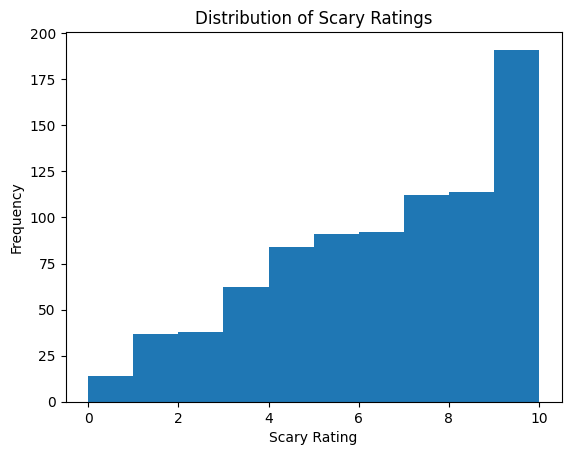

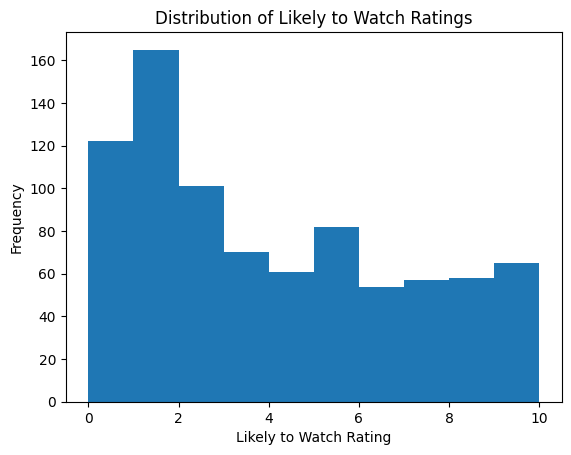

In [ ]:
plt.hist(df['Scary'], bins=10)
plt.title('Distribution of Scary Ratings')
plt.xlabel('Scary Rating')
plt.ylabel('Frequency')
plt.show()

plt.hist(df['Likely'], bins=10)
plt.title('Distribution of Likely to Watch Ratings')
plt.xlabel('Likely to Watch Rating')
plt.ylabel('Frequency')
plt.show()

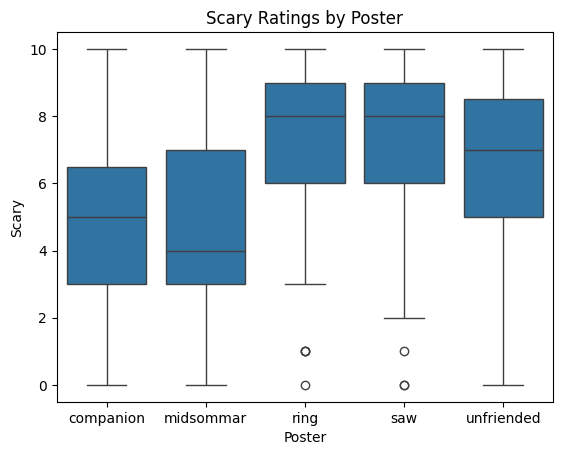

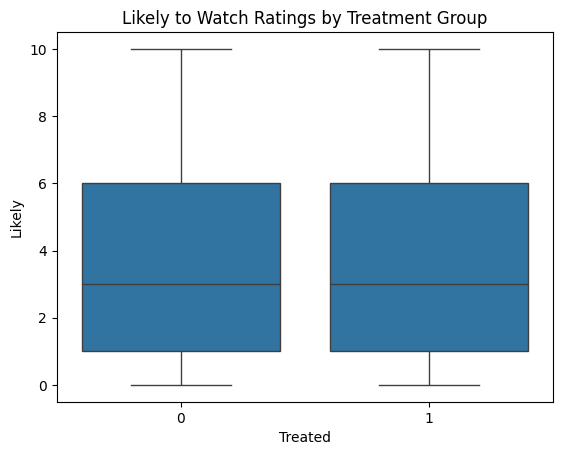

In [ ]:
import seaborn as sns
sns.boxplot(x='Poster', y='Scary', data=df)
plt.title('Scary Ratings by Poster')
plt.show()

sns.boxplot(x='Treated', y='Likely', data=df)
plt.title('Likely to Watch Ratings by Treatment Group')
plt.show()

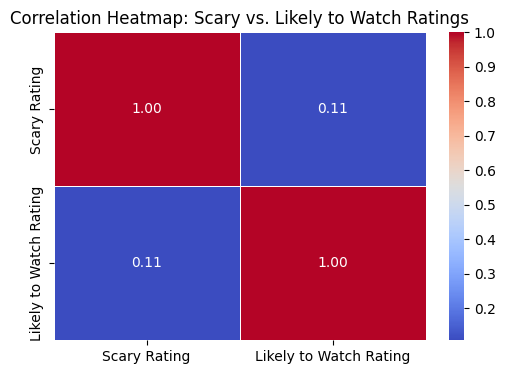

In [ ]:
movies = ["Companion", "Rings", "Midsommar", "Saw", "Unfriended"]
data_list = []
for movie in movies:
    for condition in ["Treatment", "Control"]:
        scary_col = f"{movie} {condition}_1"
        watch_col = f"{movie} {condition}_2"
        if scary_col in movies_data.columns and watch_col in movies_data.columns:
            temp_df = movies_data[[scary_col, watch_col]].copy()
            temp_df.columns = ["Scary Rating", "Likely to Watch Rating"]
            temp_df["Movie Poster"] = movie
            temp_df["Condition"] = condition
            data_list.append(temp_df)
long_df = pd.concat(data_list, ignore_index=True)
corr_matrix = long_df[["Scary Rating", "Likely to Watch Rating"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Scary vs. Likely to Watch Ratings")
plt.show()

# **Statistical Analysis**

In [ ]:
df['gender'] = df['gender'].apply(lambda x: 3 if x > 2 else x)
df['age_group'] = df['age_group'].apply(lambda x: 6 if x > 5 else x)

In [ ]:
df['age_group'].value_counts()

,count
age_group,
3,300
2,280
5,105
4,70
6,50
1,30


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             835 non-null    object 
 1   Poster         835 non-null    object 
 2   Treated        835 non-null    int64  
 3   Scary          835 non-null    float64
 4   Likely         835 non-null    float64
 5   gender         835 non-null    int64  
 6   age_group      835 non-null    int64  
 7   latitude       835 non-null    float64
 8   longitude      835 non-null    float64
 9   social_usage   835 non-null    int64  
 10  social_prefer  835 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 71.9+ KB


## Proportions Test to Check for Balance

In [ ]:
covariates = ['gender', 'age_group', 'social_usage', 'social_prefer']

results = []

for cov in covariates:
    treated_counts = df[df['Treated'] == 1][cov].value_counts().sort_index()
    control_counts = df[df['Treated'] == 0][cov].value_counts().sort_index()
    levels = treated_counts.index.union(control_counts.index)

    treated_counts = treated_counts.reindex(levels, fill_value=0)
    control_counts = control_counts.reindex(levels, fill_value=0)

    for level in levels:
        count = np.array([treated_counts[level], control_counts[level]])
        nobs = np.array([df[df['Treated'] == 1].shape[0], df[df['Treated'] == 0].shape[0]])

        z_stat, p_val = proportions_ztest(count, nobs)

        results.append([cov, level, treated_counts[level], control_counts[level], round(z_stat, 3), round(p_val, 3)])

balance_results = pd.DataFrame(results, columns=["Covariate", "Level", "Treated Count", "Control Count", "Z-Statistic", "P-Value"])
balance_results

,Covariate,Level,Treated Count,Control Count,Z-Statistic,P-Value
0,gender,1,212,218,-0.308,0.758
1,gender,2,188,187,0.163,0.870
2,gender,3,16,14,0.392,0.695
3,age_group,1,16,14,0.392,0.695
4,age_group,2,145,135,0.807,0.420
5,age_group,3,147,153,-0.355,0.723
6,age_group,4,32,38,-0.718,0.473
7,age_group,5,48,57,-0.900,0.368
8,age_group,6,28,22,0.901,0.367
9,social_usage,1,78,87,-0.731,0.465


Since all the p-values are greater than 0.05, the treatment and control groups can be said to be well-balanced. This is because we fail to accept the null hypothesis that randomization was conducted improperly.

## T-Test to Check for Significant Differences between Treatment and Control

In [ ]:
for outcome in ['Scary', 'Likely']:
    treated = df[df['Treated'] == 1][outcome]
    control = df[df['Treated'] == 0][outcome]

    t_stat, p_value = ttest_ind(treated, control, equal_var=False)
    print(f"T-test for {outcome}: t-stat = {t_stat:.3f}, p-value = {p_value:.3f}")

T-test for Scary: t-stat = 0.097, p-value = 0.923
T-test for Likely: t-stat = 0.322, p-value = 0.748


Since the p-value is not greater than 0.05, we cannot say that the treatment has a significant effect.

## ATE without Covariates

In [ ]:
X = df[['Treated']]
X = sm.add_constant(X)

Y_scary = df['Scary']
Y_likely = df['Likely']

model_scary = sm.OLS(Y_scary, X).fit()
model_likely = sm.OLS(Y_likely, X).fit()

p_value_scary = round(model_scary.pvalues['Treated'], 3)
p_value_likely = round(model_likely.pvalues['Treated'], 3)

stargazer = Stargazer([model_scary, model_likely])
stargazer.title("Overall Average Treatment Effect without Covariates")
stargazer.custom_columns(["Scariness", "Likelihood to Watch"], [1,1])
stargazer.add_line("p-value", [p_value_scary, p_value_likely])
stargazer

### ATE without Covariates for Poster Scariness, Per Poster

In [ ]:
models = []
posters = df['Poster'].unique()

for poster in posters:
    subset = df[df['Poster'] == poster]
    X = subset[['Treated']]
    X = sm.add_constant(X)
    y = subset['Scary']

    model = sm.OLS(y, X).fit()
    models.append(model)

stargazer = Stargazer(models)
stargazer.title("Overall Average Treatment Effect without Covariates Per Poster")
stargazer.custom_columns(posters.tolist(), [1] * len(posters))
stargazer

### ATE without Covariates for Likeliness to Watch, Per Poster

In [ ]:
models = []
posters = df['Poster'].unique()

for poster in posters:
    subset = df[df['Poster'] == poster]
    X = subset[['Treated']]
    X = sm.add_constant(X)
    y = subset['Likely']

    model = sm.OLS(y, X).fit()
    models.append(model)

stargazer = Stargazer(models)
stargazer.title("Overall Average Treatment Effect without Covariates Per Poster")
stargazer.custom_columns(posters.tolist(), [1] * len(posters))
stargazer

## ATE with Covariates

In [ ]:
X = df[['Treated', 'age_group', 'gender', 'social_usage', 'social_prefer']]
X = sm.add_constant(X)

Y_scary = df['Scary']
Y_likely = df['Likely']

model_scary = sm.OLS(Y_scary, X).fit()
model_likely = sm.OLS(Y_likely, X).fit()

p_value_scary = round(model_scary.pvalues['Treated'], 3)
p_value_likely = round(model_likely.pvalues['Treated'], 3)

stargazer = Stargazer([model_scary, model_likely])
stargazer.title("Overall Average Treatment Effect with Covariates")
stargazer.custom_columns(["Scariness", "Likelihood to Watch"], [1,1])
stargazer.add_line("p-value", [p_value_scary, p_value_likely])
stargazer

### ATE with Covariates for Poster Scariness, Per Poster

In [ ]:
models = []
posters = df['Poster'].unique()

for poster in posters:
    subset = df[df['Poster'] == poster]
    X = subset[['Treated', 'gender', 'age_group', 'social_usage', 'social_prefer']]
    X = sm.add_constant(X)
    y = subset['Scary']

    model = sm.OLS(y, X).fit()
    models.append(model)

stargazer = Stargazer(models)
stargazer.title("Average Treatment Effect Per Poster")
stargazer.custom_columns(posters.tolist(), [1] * len(posters))
stargazer

### ATE with Covariates for Likeliness to Watch, Per Poster

In [ ]:
models = []
posters = df['Poster'].unique()

for poster in posters:
    subset = df[df['Poster'] == poster]
    X = subset[['Treated', 'gender', 'age_group', 'social_usage', 'social_prefer']]
    X = sm.add_constant(X)
    y = subset['Likely']

    model = sm.OLS(y, X).fit()
    models.append(model)

stargazer = Stargazer(models)
stargazer.title("Average Treatment Effect Per Poster")
stargazer.custom_columns(posters.tolist(), [1] * len(posters))
stargazer

## Average Treatment Effects Conditional on Each Gender & Age Group

### Gender

In [ ]:
models = []
genders = {1: "Male", 2: "Female", 3: "Other"}

for gender in genders.keys():
    subset = df[df['gender'] == gender]

    X = subset[['Treated', 'age_group', 'social_usage', 'social_prefer']]
    X = sm.add_constant(X)

    y = subset['Scary']

    model = sm.OLS(y, X).fit()
    models.append(model)

column_labels = [genders[g] for g in genders.keys()]

stargazer = Stargazer(models)
stargazer.title("Overall Average Treatment Effect Conditional on Gender")
stargazer.custom_columns(column_labels, [1] * len(column_labels))

stargazer

In [ ]:
models = []
genders = {1: "Male", 2: "Female", 3: "Other"}

for gender in genders.keys():
    subset = df[df['gender'] == gender]

    X = subset[['Treated', 'age_group', 'social_usage', 'social_prefer']]
    X = sm.add_constant(X)

    y = subset['Likely']

    model = sm.OLS(y, X).fit()
    models.append(model)

column_labels = [genders[g] for g in genders.keys()]

stargazer = Stargazer(models)
stargazer.title("Overall Average Treatment Effect Conditional on Gender")
stargazer.custom_columns(column_labels, [1] * len(column_labels))

stargazer

#### Gender, Per Poster

In [ ]:
models = []
posters = df['Poster'].unique()
genders = {1: "Male", 2: "Female", 3: "Other"}

for gender in genders.keys():
    gender_models = []

    for poster in posters:
        subset = df[(df['Poster'] == poster) & (df['gender'] == gender)]

        X = subset[['Treated', 'age_group', 'social_usage', 'social_prefer']]
        X = sm.add_constant(X)

        y = subset['Scary']

        model = sm.OLS(y, X).fit()
        gender_models.append(model)

    models.append(gender_models)

flattened_models = [model for sublist in models for model in sublist]

column_labels = [f"{poster} ({genders[g]})" for g in genders.keys() for poster in posters]

stargazer = Stargazer(flattened_models)
stargazer.title("Average Treatment Effect Conditional on Gender")
stargazer.custom_columns(column_labels, [1] * len(column_labels))

stargazer

In [ ]:
models = []
posters = df['Poster'].unique()
genders = {1: "Male", 2: "Female", 3: "Other"}

for gender in genders.keys():
    gender_models = []

    for poster in posters:
        subset = df[(df['Poster'] == poster) & (df['gender'] == gender)]

        X = subset[['Treated', 'age_group', 'social_usage', 'social_prefer']]
        X = sm.add_constant(X)

        y = subset['Likely']

        model = sm.OLS(y, X).fit()
        gender_models.append(model)

    models.append(gender_models)

flattened_models = [model for sublist in models for model in sublist]

column_labels = [f"{poster} ({genders[g]})" for g in genders.keys() for poster in posters]

stargazer = Stargazer(flattened_models)
stargazer.title("Average Treatment Effect Conditional on Gender")
stargazer.custom_columns(column_labels, [1] * len(column_labels))

stargazer

### Age Group

In [ ]:
# regenerate png output
models = []
age_groups = {1: "Below 18", 2: "18 to 24", 3: "25 to 34", 4: "35 to 44", 5: "45 to 54", 6: "55+"}

for age_group in age_groups.keys():
    subset = df[df['age_group'] == age_group]

    X = subset[['Treated', 'gender', 'social_usage', 'social_prefer']]
    X = sm.add_constant(X)

    y = subset['Scary']

    model = sm.OLS(y, X).fit()
    models.append(model)

column_labels = [age_groups[a] for a in age_groups.keys()]

stargazer = Stargazer(models)
stargazer.title("Overall Average Treatment Effect Conditional on Age Group")
stargazer.custom_columns(column_labels, [1] * len(column_labels))

stargazer

In [ ]:
models = []
age_groups = {1: "Below 18", 2: "18 to 24", 3: "25 to 34", 4: "35 to 44", 5: "45 to 54", 6: "55+"}

for age_group in age_groups.keys():
    subset = df[df['age_group'] == age_group]

    X = subset[['Treated', 'gender', 'social_usage', 'social_prefer']]
    X = sm.add_constant(X)

    y = subset['Likely']

    model = sm.OLS(y, X).fit()
    models.append(model)

column_labels = [age_groups[a] for a in age_groups.keys()]

stargazer = Stargazer(models)
stargazer.title("Overall Average Treatment Effect Conditional on Age Group")
stargazer.custom_columns(column_labels, [1] * len(column_labels))

stargazer

#### Age Group, Per Poster

In [ ]:
models = []
posters = df['Poster'].unique()
age_groups = {1: "Below 18", 2: "18 to 24", 3: "25 to 34", 4: "35 to 44", 5: "45 to 54", 6: "55+"}

for age_group in age_groups.keys():
    age_groups_models = []

    for poster in posters:
        subset = df[(df['Poster'] == poster) & (df['age_group'] == age_group)]

        X = subset[['Treated', 'gender', 'social_usage', 'social_prefer']]
        X = sm.add_constant(X)

        y = subset['Scary']

        model = sm.OLS(y, X).fit()
        age_groups_models.append(model)

    models.append(age_groups_models)

flattened_models = [model for sublist in models for model in sublist]

column_labels = [f"{poster} ({age_groups[a]})" for a in age_groups.keys() for poster in posters]

stargazer = Stargazer(flattened_models)
stargazer.title("Average Treatment Effect Conditional on Age Group")
stargazer.custom_columns(column_labels, [1] * len(column_labels))

stargazer

In [ ]:
models = []
posters = df['Poster'].unique()
age_groups = {1: "Below 18", 2: "18 to 24", 3: "25 to 34", 4: "35 to 44", 5: "45 to 54", 6: "55+"}

for age_group in age_groups.keys():
    age_groups_models = []

    for poster in posters:
        subset = df[(df['Poster'] == poster) & (df['age_group'] == age_group)]

        X = subset[['Treated', 'gender', 'social_usage', 'social_prefer']]
        X = sm.add_constant(X)

        y = subset['Likely']

        model = sm.OLS(y, X).fit()
        age_groups_models.append(model)

    models.append(age_groups_models)

flattened_models = [model for sublist in models for model in sublist]

column_labels = [f"{poster} ({age_groups[a]})" for a in age_groups.keys() for poster in posters]

stargazer = Stargazer(flattened_models)
stargazer.title("Average Treatment Effect Conditional on Age Group")
stargazer.custom_columns(column_labels, [1] * len(column_labels))

stargazer